Artis Vijups, October 24, 2024

# Background on elections in the United Kingdom

For election purposes, the UK is divided into 650 constituencies with similar populations. Each constituency elects 1 member to the UK Parliament. The elected candidate is the one who receives a plurality of votes within the constituency (more votes than any one other candidate).

On election night, one announcement is made per constituency, which is of the final result in that constituency - how many votes each candidate received, and which candidate is therefore elected. No partial results are published beforehand.

In the 2017 election, five parties won multiple seats in Great Britain: Labour (Lab), the Conservatives (Con), Liberal Democrats (LD), Scottish National Party (SNP) and Plaid Cymru (PC).

# The project

The goal of the project is to create a statistical model that can predict how many constituencies each of the five considered parties is going to win in the 2019 UK election, given a set of the first constituency results that were announced, as well as the results of the three previous elections (2017, 2015, 2010) in each constituency, results from the 2016 Brexit referendum, and census data about each constituency from 2011.

In particular, the purpose is to predict the number of constituencies each of the parties will win out of the remaining constituencies.

The complete project, including the original Jupyter notebook `.ipynb` file, is available in a [GitHub repository](https://github.com/artis-v/BERN02-project).

All data is sourced from the [House of Commons Library](https://commonslibrary.parliament.uk/), which licenses its content under the [Open Parliament Licence v3.0](https://www.parliament.uk/site-information/copyright-parliament/open-parliament-licence/).

# Workflow

In [1]:
library(dplyr, warn.conflicts = FALSE)
library(tidyr)
library(readxl)
library(mgsub)
library(nnet)
library(ggplot2)
library(sf)

Linking to GEOS 3.11.2, GDAL 3.8.2, PROJ 9.3.1; sf_use_s2() is TRUE



## Reading the data

We begin by setting up three vectors for the five considered parties, the parties including Oth (Others), and party colors.

In [2]:
considered_parties <- c("Lab", "Con", "LD", "SNP", "PC")
parties <- c(considered_parties, "Oth")
colors <- c("red", "blue", "orange", "black", "darkgreen", "gray")

We create a function `read` that can read a CSV file containing the results of an election, and return a data frame with 650 rows: one row per constituency, containing its name, country (England, Scotland, Wales or Northern Ireland) and each party's vote share.

In [3]:
read <- function(file, prefix = ""){
    # read file and only keep necessary columns
    res <- read.csv(file)[, c("Country.name", "Constituency.name", "Main.party.abbreviation", "Candidate.vote.share")]

    # rename columns
    colnames(res) <- c("country", "constituency", "party", "share")

    # let all non-considered parties be Oth
    res <- res %>% mutate(party = ifelse(party %in% considered_parties, party, "Oth"))

    # add up the vote share for Oth
    res <- aggregate(share ~ . - share, data = res, FUN = sum)

    # pivot to one row per constituency
    res <- res %>% pivot_wider(names_from = party, values_from = share, names_prefix = prefix)

    # if a party got no votes, put 0% share
    res <- res %>% mutate(across(everything(), ~replace(., is.na(.), 0.)))

    return(res)
}

We create a function `census` that can read a sheet from the 2011 Census data spreadsheet, and return a data frame containing the requested columns of information.

In [4]:
census <- function(sheet_name, columns, column_names){
    # read relevant sheet
    sheet <- read_excel("census2011.xlsx", sheet = sheet_name, .name_repair = "unique_quiet")
    
    # retain only the requested columns
    keep <- sheet[5:654, c(2, columns)]
    colnames(keep) <- c("constituency", column_names)
    
    # align constituency names with the result CSV files
    keep$constituency <- mgsub(keep$constituency,
        c("-under", "-on", "-upon", "upon Tyne", "an Iar", " of", "Pembrokeshire South"),
        c("-Under", "-On", "-Upon", "Upon Tyne", "An Iar", " Of", "South Pembrokeshire"))
    
    # turn strings into numbers between 0 and 1
    keep[column_names] <- as.data.frame(lapply(keep[column_names], function(x) { as.numeric(x) / 100 }))
    
    return(keep)
}

We use these functions to create `res`, a data frame containing the results from the past three elections and census data.

Observe that the constituencies in Northern Ireland, and the Chorley constituency, are not included in `res`. This is because the five considered parties chose not to contest these constituencies in advance of the 2019 election. Therefore, Oth is the guaranteed winner.

In [5]:
# read election results
res <- read("results2017.csv", "17.")
res <- merge(res, read("results2015.csv", "15."), by = cbind("country", "constituency"))
res <- merge(res, read("results2010.csv", "10."), by = cbind("country", "constituency"))

# remove NI and Chorley
res <- filter(res, country != "Northern Ireland")
res <- filter(res, constituency != "Chorley")

# remaining number of constituencies
model_constituencies <- 631

# include census data
res <- merge(res, 
             census("KS101D", 12, "Gender.Male"), 
             by = "constituency")
res <- merge(res, 
             census("KS102D", c(114, 120, 126, 132), c("Age.16.24", "Age.25.44", "Age.45.64", "Age.65.Up")), 
             by = "constituency")
res <- merge(res, 
             census("KS105D", c(12, 30), c("Composition.Alone", "Composition.Family")), 
             by = "constituency")
res <- merge(res, 
             census("KS106D", 12, "All.Unemployed"), 
             by = "constituency")
res <- merge(res, 
             census("KS201D", c(12, 42, 72, 108), c("Eth.White", "Eth.Mixed", "Eth.Asian", "Eth.Black")), 
             by = "constituency")
res <- merge(res, 
             census("KS204D", c(12, 54, 72), c("Born.UK", "Born.EU", "Born.Other")), 
             by = "constituency")
res <- merge(res, 
             census("KS301D", c(12, 18, 24, 30, 36), c("Health.VG", "Health.G", "Health.F", "Health.B", "Health.VB")), 
             by = "constituency")
res <- merge(res, 
             census("KS402D", c(18, 24, 36, 54), c("House.Own", "House.Mortgage", "House.Social", "House.Rent")), 
             by = "constituency")
res <- merge(res, 
             census("KS501D", c(12, 18, 24, 36, 42), c("No.Qual", "Lev.1", "Lev.2", "Lev.3", "Lev.4")), 
             by = "constituency")
res <- merge(res, 
             census("KS601D", 42, "Unemployed"), 
             by = "constituency")

We also add the results from the estimated results by constituency of 2016 Brexit referendum.

In [6]:
# read referendum spreadsheet, keep only needed constituencies and leave vote
ref <- read_excel("referendum.xlsx", sheet = "DATA", .name_repair = "unique_quiet", skip = 5)[3:652, 1:3]
colnames(ref) <- c("code", "constituency", "Voted.Leave")
ref <- filter(ref, !(startsWith(code, "N")))
ref <- filter(ref, !(constituency == "Chorley"))
ref <- within(ref, rm(code))

# align constituency names with the result CSV files
ref$constituency <- mgsub(ref$constituency,
    c("-under", "-on", "-upon", "upon Tyne", "an Iar", " of", "Ynys Mon"),
    c("-Under", "-On", "-Upon", "Upon Tyne", "An Iar", " Of", "Ynys Môn"))

# merge into res
res <- merge(res, ref, by = "constituency")

Next, we read the CSV file containing the times at which each constituency declared its results, and let `times` be a vector containing the 631 constituencies in order of declaration time.

In [7]:
# read CSV of declaration times
times <- read.csv("times2019.csv")

# remove NI and Chorley
times <- filter(times, !(startsWith(Constituency.geographic.code, "N")))
times <- filter(times, !(Constituency.name == "Chorley"))

# keep vector of constituencies in declaration time order
times <- times[["Constituency.name"]]

Finally, we create `full_res`, which is a version of `res` that includes the 2019 results and is ordered by declaration time.

In [8]:
# add 2019 results
full_res <- merge(res, read("results2019.csv"), by = cbind("country", "constituency"))

# sort by declaration time
full_res <- full_res %>% arrange(factor(constituency, levels = times))

## Creating the model

If we were to only consider two parties, a reasonable choice for a statistical model would be a logistic regression model. This is because the response variable would be binary: either the first party wins, or the second party wins.

However, instead of two possible responses, we have six (Lab, Con, LD, SNP, PC, Oth). Section 4.3.5 of the BERN02 course textbook proposes multinomial logistic regression as a way of generalizing logistic regression to more than two response classes. This is the method used in this project.

Representing the coefficients with $\beta$ and observations with $x,$ the model can be expressed with the equations \begin{align*}\mathbb{P}(\text{winner}=\text{party})&=\dfrac{1}{1+\sum_{p\in\text{parties}\backslash\text{Lab}}e^{\beta_{p0}}+e^{\beta_{p1}}x_1+e^{\beta_{p2}}x_2+\ldots}\qquad\text{if party is Lab},\\\mathbb{P}(\text{winner}=\text{party})&=\dfrac{e^{\beta_{\text{party}0}}+e^{\beta_{\text{party}1}}x_1+e^{\beta_{\text{party}2}}x_2+\ldots}{1+\sum_{p\in\text{parties}\backslash\text{Lab}}e^{\beta_{p0}}+e^{\beta_{p1}}x_1+e^{\beta_{p2}}x_2+\ldots}\qquad\text{otherwise}.\end{align*}

Observe that $\sum_{\text{party}\in\text{parties}}\mathbb{P}(\text{winner}=\text{party})=1$. This allows us to interpret the individual probabilities as the vote shares in the constituency.

In R, this type of model can be created using the `nnet::multinom()` function. We use all the included past election and census data as predictors, and the results from 2019 as the response variables.

The `slate` function creates this model using the data from a number `called` of constituencies that declared their results first, and then makes predictions for the remaining constituencies. This function returns the vote share each party has received.

In [9]:
slate <- function(called){
    # return empty data frame if nothing to predict
    if(called == model_constituencies){
        return(data.frame())
    }
    
    # make data frame of called constituencies
    full_sample <- full_res %>% slice(1 : called)
    full_sample <- within(full_sample, rm("constituency"))
    full_sample <- full_sample %>% 
        mutate(country = case_when(country == "Wales" ~ -1, country == "England" ~ 0, country == "Scotland" ~ 1))
    
    # create the multinomial logistic regression model
    model_formula <- paste("cbind(", paste(unlist(parties), collapse = ", "), ") ~ .")
    model <- multinom(as.formula(model_formula), data = full_sample, trace = FALSE)
    
    # make data frame of uncalled constituencies
    full_todo <- full_res %>% slice(called + 1 : model_constituencies)
    full_todo <- full_todo %>% 
        mutate(country = case_when(country == "Wales" ~ -1, country == "England" ~ 0, country == "Scotland" ~ 1))
    
    # predict the results in each constituency
    pred <- predict(model, newdata = full_todo, type = "probs")
    
    # return data frame with the share of the vote by party in each constituency
    if(called == model_constituencies - 1){
        pred <- as.data.frame(t(pred))
    }
    pred <- cbind(full_todo$constituency, pred)
    return(pred)
}

The `seats` function returns the predicted total number of constituencies won by each party, using the data frame of vote shares returned by `slate`.

In [10]:
seats <- function(called){
    # get predicted vote shares
    pred <- slate(called)
    
    # list the winners in all constituencies
    if(called == model_constituencies){
        winners <- c(parties[apply(full_res[, parties], 1, which.max)])
    }else{
        winners <- c(parties[apply(full_res[, parties], 1, which.max)][1 : called], 
                     parties[apply(pred[, parties], 1, which.max)])
    }
    
    # turn into a data frame, adding 19 to Oth
    party_counts <- table(winners)
    party_vector <- setNames(rep(0, length(parties)), parties)
    party_vector[names(party_counts)] <- as.vector(party_counts)
    party_vector["Oth"] <- party_vector["Oth"] + 19
    party_df <- as.data.frame(as.list(party_vector))
    return(party_df)
}

## Results and visualisations

First, we make a graph of the predicted total number of constituencies won by each party in the election, depending on the number of constituencies whose results were made available for creating the model.

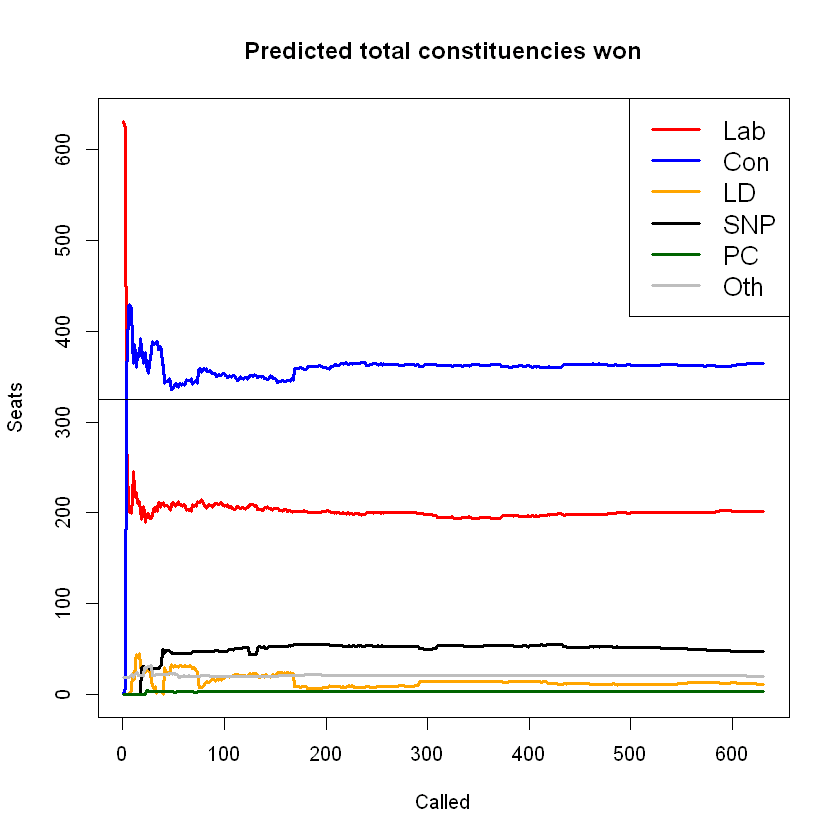

In [11]:
# get predictions
range <- c(1:631)
predictions <- lapply(range, seats)
predictions <- do.call(rbind, predictions)

# plot
matplot(range, predictions[parties], type = "l", lty = 1,
        xlab = "Called", ylab = "Seats", lwd = 3, col = colors)
legend("topright", legend = parties, col = colors, lty = 1, lwd = 3, cex = 1.3)
title("Predicted total constituencies won")
abline(h = 325)

The model first predicted a Conservative majority in parliament when the Blyth Valley constituency was called at 23:32 PM. This was the 3rd of 650 results declared.

From there on in, as shown in the graph above, the model always predicted a Conservative majority, which ended up being the actual outcome of the election.

In [12]:
summarize <- function(call_number){
    # get predictions before call
    p <- slate(call_number - 1)
    
    # combine constituency prediction with actual result and 2017 result
    r2017 <- full_res[call_number, paste0("17.", parties)]
    colnames(r2017) <- parties
    df <- rbind(r2017, p[1, parties], full_res[call_number, parties])
    
    # format as percentages
    df <- as.data.frame(lapply(df, function(x) { paste(round(as.numeric(x) * 100, 2), "%", sep = "") }))
    
    # add predicted and actual totals
    df <- rbind(df, seats(call_number - 1), seats(call_number), seats(model_constituencies))
    
    # return data frame
    rownames(df) <- c(paste("2017: Actual share in", full_res[call_number, "constituency"]),
                      paste("2019: Predicted share in", full_res[call_number, "constituency"]),
                      paste("2019: Actual share in", full_res[call_number, "constituency"]), 
                      "Predicted total before", 
                      "Predicted total after",
                      "Actual total")
    return(df)
}

print(summarize(3))

                                         Lab    Con    LD SNP PC    Oth
2017: Actual share in Blyth Valley    55.94% 37.31% 4.58%  0% 0%  2.16%
2019: Predicted share in Blyth Valley 41.29% 32.56% 6.02%  0% 0% 20.13%
2019: Actual share in Blyth Valley    40.94% 42.68% 5.26%  0% 0% 11.11%
Predicted total before                   623      8     0   0  0     19
Predicted total after                    275    356     0   0  0     19
Actual total                             202    365    11  48  4     20


One posterior method for seeing how the model has performed is to determine the ratio of predictions that were wrong. We create a `get_wrong` function that finds all incorrectly predicted constituencies, and have `get_ratio` compute the corresponding ratio.

In [13]:
get_wrong <- function(called){
    if(called == model_constituencies){
        return(0)
    }
    
    # make data frame of constituencies, predicted winners and actual winners
    p <- as.data.frame(slate(called))
    p <- cbind(p, parties[apply(p[, parties], 1, which.max)])
    p <- cbind(p, parties[apply(tail(full_res, model_constituencies - called)[, parties], 1, which.max)])
    colnames(p) <- c("constituency", parties, "prediction", "winner")
    
    # return incorrect predictions
    wrong <- filter(p, prediction != winner)
    return(wrong[c("constituency", "prediction", "winner")])
}

get_ratio <- function(called) {
    return(nrow(get_wrong(called)) / (model_constituencies - called))
}

We can then plot the ratios of incorrect predictions.

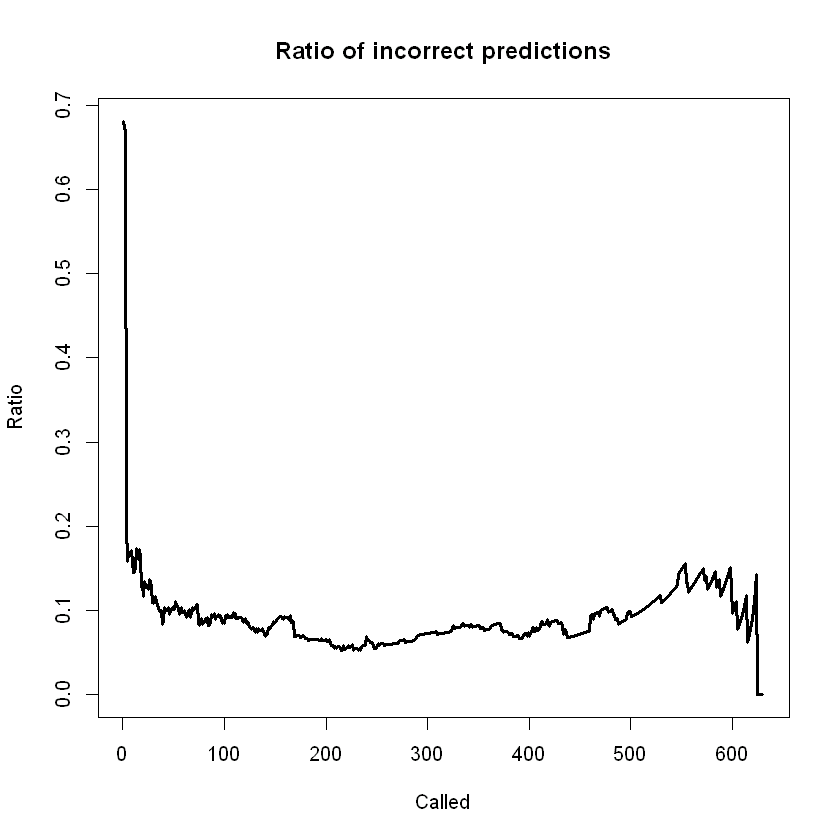

In [14]:
ratios <- lapply(range, get_ratio)
matplot(range, ratios, xlab = "Called", ylab = "Ratio", type = "l", lty = 1, lwd = 3)
title("Ratio of incorrect predictions")

Finally, a very common visualisation of electoral results is by way of a cartogram. In it, each constituency is made to have the same size, since each constituency elects one person. We create one such cartogram for the predicted result at 2:54 AM, when the results from Twickenham and from Stevenage came in.

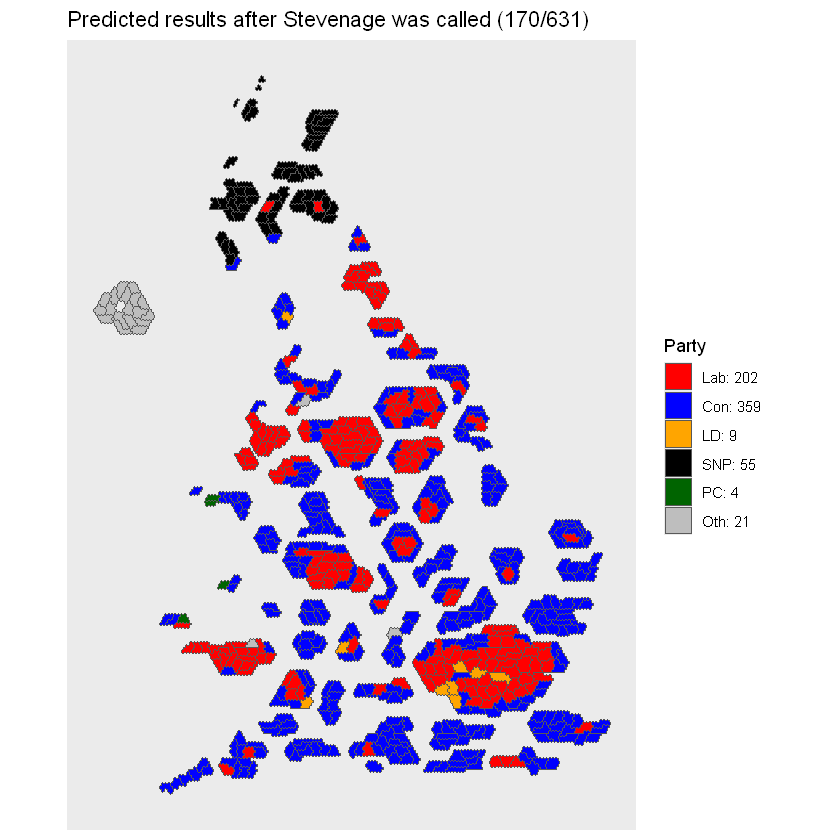

In [15]:
# read map file
gpkg_file <- "constituencies.gpkg"
gpkg_cons <- st_read(gpkg_file, layer = "4 Constituencies", quiet = TRUE)

# create data frame of constituencies, winners and party colors
show <- 170
p <- slate(show)
colnames(p) <- c("constituency", parties)
p <- rbind(full_res[1 : show, c("constituency", parties)], p)
colnames(p) <- c("pcon.name", parties)
p$winner <- parties[apply(p[, parties], 1, which.max)]
p$color <- setNames(colors, parties)[p$winner]
p <- p[c("pcon.name", "winner", "color")]

# rename constituencies to align with map file
p$pcon.name <- mgsub(p$pcon.name,
    c(" Of", "-On", "Upon", "Under", "Môn", "An Iar"),
    c(" of", "-on", "upon", "under", "Mon", "an Iar"))

# add previously removed constituencies
missing <- data.frame(pcon.name = setdiff(gpkg_cons[["pcon.name"]], p[["pcon.name"]]))
missing$winner <- "Oth"
missing$color <- "gray"
p <- rbind(p, missing)

# add winners and party colors to map file
gpkg_cons <- gpkg_cons %>% left_join(p, by = "pcon.name")

# plot
plt <- ggplot(data = gpkg_cons) + geom_sf(aes(fill = color)) + 
       scale_fill_identity(breaks = colors, labels = paste(parties, seats(show)[1, ], sep = ": "), 
                           name = "Party", guide = "legend") + 
       coord_sf(datum = NA) + 
       labs(title = paste("Predicted results after ", full_res[show, "constituency"], 
                          " was called (", show, "/", model_constituencies, ")", sep = ""))
plt

We can also create a cartogram emphasizing the incorrectly predicted constituencies. 

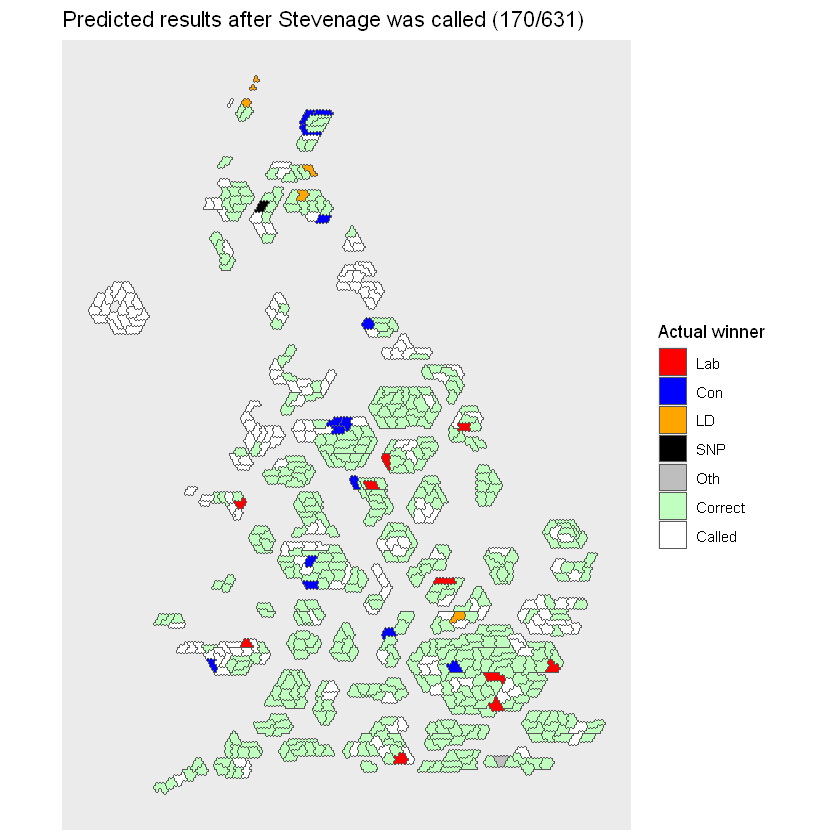

In [16]:
# read map file
gpkg_file <- "constituencies.gpkg"
gpkg_cons <- st_read(gpkg_file, layer = "4 Constituencies", quiet = TRUE)

# amend p to color correct predictions green
wrong <- get_wrong(show)
wrong <- within(wrong, rm("prediction"))
colnames(wrong) <- c("pcon.name", "winner")
wrong$color <- setNames(colors, parties)[wrong$winner] 
p <- p %>% left_join(wrong, by = "pcon.name", suffix = c("", "_new")) 
p <- p %>%
  mutate(winner = ifelse(!is.na(winner_new), winner_new, "Correct")) %>%
  mutate(color = ifelse(!is.na(color_new), color_new, "darkseagreen1")) %>%
  select(-winner_new) %>%
  select(-color_new)

# color called constituencies white
p[1 : show, ]$winner <- "Called"
p[1 : show, ]$color <- "white"
p[(model_constituencies + 1) : 650, ]$winner <- "Called"
p[(model_constituencies + 1) : 650, ]$color <- "white"

# add winners and party colors to map file
gpkg_cons <- gpkg_cons %>% left_join(p, by = "pcon.name")

# plot
plt <- ggplot(data = gpkg_cons) + geom_sf(aes(fill = color)) + 
       scale_fill_identity(breaks = c(colors, "darkseagreen1", "white"), 
                           labels = c(parties, "Correct", "Called"), 
                           name = "Actual winner", guide = "legend") + 
       coord_sf(datum = NA) + 
       labs(title = paste("Predicted results after ", full_res[show, "constituency"], 
                          " was called (", show, "/", model_constituencies, ")", sep = ""))
plt

# Notes

## Possible improvements

One limitation of the solution is that it is computationally heavy. Two of the generated graphs each require about a minute to be plotted.

The way the problem in the project is defined, it's not exactly clear at what point the model should be evaluated for its performance. A more specific problem task, like creating a model using the first half of constituency results, would be helpful.

Also, for some constituencies, the predicted vote shares are unrealistic. One example is the predicted vote share in Twickenham for the Liberal Democrats, right before the constituency is called.

In [17]:
print(summarize(169))

                                      Lab    Con     LD SNP PC   Oth
2017: Actual share in Twickenham    9.22% 38.03% 52.75%  0% 0%    0%
2019: Predicted share in Twickenham  3.6%    13% 81.74%  0% 0% 1.67%
2019: Actual share in Twickenham    8.49% 34.18% 56.07%  0% 0% 1.27%
Predicted total before                202    346     23  54  4    21
Predicted total after                 202    359      9  55  4    21
Actual total                          202    365     11  48  4    20


Since there are many predictor variables, it would be reasonable to introduce a selection method, such as forward stepwise selection. Having less predictors as a result can help avoid outlying predictions like this. However, this makes the workflow slower.

Also, the model uses only fixed effects. Introducing random effects, which are unsupported by `nnet::multinom()` and would hence require a different implementation, would be reasonable for predictors like `country`.

Finally, this project is difficult to reuse for the 2024 election because of the changes to the constituency boundaries, the lack of declaration time information for 2024 on the House of Commons Library website, and because results from prior elections have to be adapted to the new boundaries.

## FAIR principles

The project is findable, since it is stored on GitHub under a specific repository name, with relevant tags provided.

The project is accessible through the HTTPS protocol. The repository is public, and GitHub's version control ensures this current version of the project will be available.

The project is interoperable. Standard formats (`.csv`, `.xlsx`, `.gpkg`, `.txt`, `.ipynb`) are used. A `requirements.txt` file is provided for the used libraries. 

The project is reusable. The code is well-documented through comments and markdown in a Jupyter notebook. The code is modular, with functions that can be used for other visualisations and analysis. A license is specified.